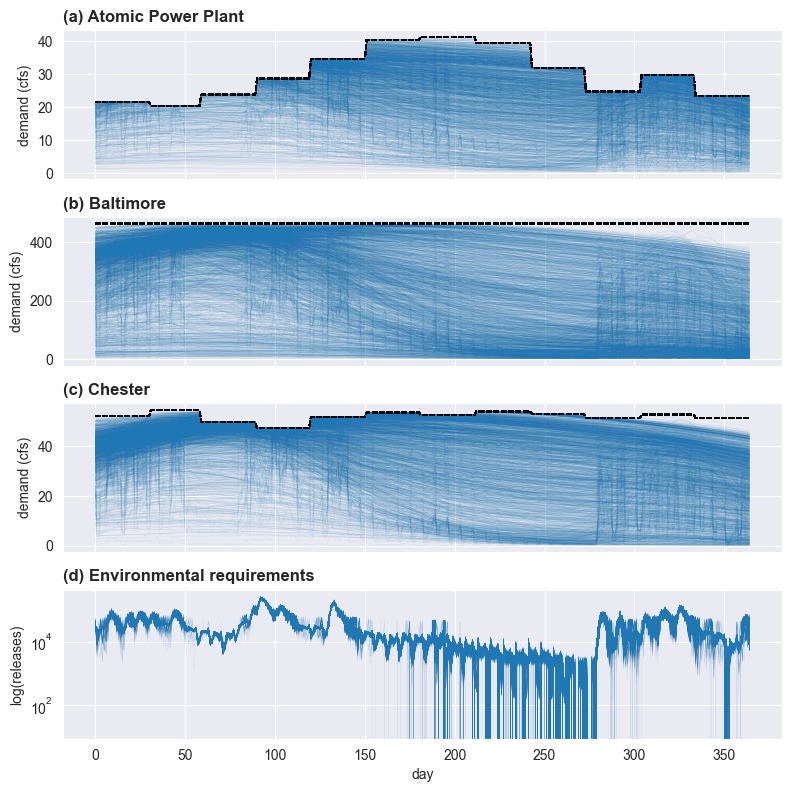

In [ ]:
import seaborn as sns
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from susquehanna_model import SusquehannaModel
import rbf_functions

logging.basicConfig(level=logging.INFO)
plt.rcParams["figure.figsize"] = [12, 8]

sys.path.append(os.path.abspath(".."))

rbfs = [
    rbf_functions.original_rbf,
    rbf_functions.squared_exponential_rbf,
    rbf_functions.inverse_quadratic_rbf,
    rbf_functions.inverse_multiquadric_rbf,
    rbf_functions.exponential_rbf,
    rbf_functions.matern32_rbf,
    rbf_functions.matern52_rbf,
]

reference_sets = {}
for entry in rbfs:
    name = entry.__name__
    reference_sets[name] = pd.read_csv(
        os.path.join("./refsets", f"{name}_refset_with_variables.csv")
    )

for filename in os.listdir("../data1999"):
    if filename.startswith("w"):
        globals()[f"{filename[:-4]}"] = np.loadtxt(f"../data1999/{filename}")
    elif filename == "min_flow_req.txt":
        globals()[f"{filename[:-4]}"] = np.loadtxt(
            os.path.join("../data1999", filename)
        )

alpha = 0.1
lw = 0.3

for entry, color in zip(rbfs, sns.color_palette()):
    name = entry.__name__
    reference_set = reference_sets[name]

    numberOfRBF = 6  # numberOfInput + 2
    n_inputs = 2  # (time, storage of Conowingo)
    n_outputs = (
        4  # Atomic, Baltimore, Chester, Downstream:- (hydropower, environmental)
    )
    n_rbfs = n_inputs + 2
    rbf = rbf_functions.RBF(n_rbfs, n_inputs, n_outputs, rbf_function=entry)

    # Initialize model
    nobjs = 6
    n_years = 1
    susquehanna_river = SusquehannaModel(
        108.5, 505.0, 5, n_years, rbf
    )  # l0, l0_MR, d0, years
    susquehanna_river.set_log(True)

    for _, row in reference_set.iloc[:, 0:32].iterrows():
        susquehanna_river.evaluate(row)

    level_CO, level_MR, ratom, rbalt, rches, renv = susquehanna_river.get_log()

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 8))  #

    for release in ratom:
        ax = axes[0]
        ax.plot(release, c=color, linewidth=lw, alpha=alpha)
        ax.plot(wAtomic, "black", ls="--", linewidth=1)
        ax.set_title("(a) Atomic Power Plant", loc="left", weight="bold")
        ax.set_ylabel("demand (cfs)")
    for release in rbalt:
        ax = axes[1]
        ax.plot(release, c=color, linewidth=lw, alpha=alpha)
        ax.plot(wBaltimore, "black", ls="--", linewidth=1)
        ax.set_title("(b) Baltimore", loc="left", weight="bold")
        ax.set_ylabel("demand (cfs)")
    for release in rches:
        ax = axes[2]
        ax.plot(release, c=color, linewidth=lw, alpha=alpha)
        ax.plot(wChester, "black", ls="--", linewidth=1)
        ax.set_title("(c) Chester", loc="left", weight="bold")
        ax.set_ylabel("demand (cfs)")
    for release in renv:
        ax = axes[3]
        ax.plot(release, c=color, linewidth=lw, alpha=alpha)
        ax.set_ylabel("log(releases)")
        ax.set_title("(d) Environmental requirements", loc="left", weight="bold")
        ax.set_yscale("log")
        ax.set_xlabel("day")
    fig.tight_layout(pad=1.0)
    plt.savefig(f"figs/{name}/{name}_releases.jpg")
    plt.savefig(f"figs/{name}/{name}_releases.pdf")
    plt.show()